# Tutorial 1: Training a spiking neural network with surrogate gradients

Friedemann Zenke (https://fzenke.net)

translated into Flux.jl to run on Julia 1.6 by Brian DePasquale (http://www.princeton.edu/~briandd/)

> For more details on surrogate gradient learning, please see: 
> Neftci, E.O., Mostafa, H., and Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks.
> https://arxiv.org/abs/1901.09948

## Introduction 

The last months have seen a surge of interest in training spiking neural networks to do meaningful computations. On the one hand, this surge was fueled by the limited accomplishment of more traditional, and often considered more biologically plausible, learning paradigms in creating functional neural networks that solve interesting computational problems. This limitation was met by the undeniable success of deep neural networks in acing a diversity of challenging computational problems. A success that has raised both the bar and the question of how well this progress would translate to spiking neural networks.

The rise of deep learning over the last decade is in large part due to GPUs and their increased computational power, growing training data sets, and --- perhaps most importantly --- advances in understanding the quirks and needs of the error back-propagation algorithm. For instance, we now know that we have to avoid vanishing and exploding gradients, a feat that can be accomplished by choice of a sensible nonlinearity, proper weight initialization, and a suitable optimizer. Powerful software packages supporting auto-differentiation have since made mangling with deep neural networks a breeze in comparison to what it used to be. This development begs the question of how much of this knowledge gain from deep learning and its tools we can leverage to train spiking neural networks. Although a complete answer to these questions cannot be given at the moment, it seems that we can learn a lot.

In this tutorial, we use insights and tools from machine learning to build, step-by-step, a spiking neural network. Explicitly, we set out with the goal of building networks that solve (simple) real-world problems. To that end, we focus on classification problems and use supervised learning in conjunction with the aforementioned back-propagation algorithm. To do this, we have to overcome a vanishing gradient problem caused by the binary nature of the spikes themselves.

In this tutorial, we will first show how a simple feed-forward spiking neural network of leaky integrate-and-fire (LIF) neurons with current-based synapses can be formally mapped to a discrete-time recurrent neural network (RNN). We will use this formulation to explain why gradients vanish at spikes and show one way of how the problem can be alleviated. Specifically, we will introduce surrogate gradients and provide practical examples of how they can be implemented in PyTorch.

## Mapping LIF neurons to RNN dynamics

The de-facto standard neuron model for network simulations in computational neuroscience is the LIF neuron model which is often formally written as a time continuous dynamical system in differential form:
$$\tau_\mathrm{mem} \frac{\mathrm{d}U_i^{(l)}}{\mathrm{d}t} = -(U_i^{(l)}-U_\mathrm{rest}) + RI_i^{(l)}$$
where $U_i$ is the membrane potential of neuron $i$ in layer $l$, $U_\mathrm{rest}$ is the resting potential, $\tau_\mathrm{mem}$ is the membrane time constant, $R$ is the input resistance, and $I_i$ is the input current. The membrane potential $U_i$ characterizes the hidden state of each neuron and, importantly, it is not directly communicated to downstream neurons. However, a neuron fires an action potential or spike at the time $t$ when its membrane voltage exceeds the firing threshold $\vartheta$. After having fired a spike, a neurons membrane voltage is reset $U_i \rightarrow U_\mathrm{rest}$. We write
$$S_i^{(l)}(t)=\sum_{k \in C_i^l} \delta(t-t_j^k)$$ 
for the spike train (ie. the sum of all spikes $C_i^l$ emitted by neuron $i$ in layer $l$). Here $\delta$ is the Dirac delta function and $t_i^k$ are the associated firing times of the neuron.

Spikes travel down the axon and generate a postsynaptic currents in connected neurons. Using our above formalism we can thus write
$$\frac{\mathrm{d}I_i}{\mathrm{d}t}= -\frac{I_i(t)}{\tau_\mathrm{syn}} + \sum_j W_{ij} S_j^{(0)}(t) + \sum_j V_{ij} S_j^{(1)}(t)$$
where we have introduced the synaptic weight matrices $W_{ij}$ (feed-forward), $V_{ij}$ (recurrent), and the synaptic decay time constant $\tau_\mathrm{syn}$.

To link to RNNs apparent, we will now express the above equations in discrete time. In the interest of brevity we switch to natural units $U_\mathrm{rest}=0$, $R=1$, and $\vartheta=1$. Our arguments remain unaffected by this choice, and all results can always be re-scaled back to physical units. To highlight the nonlinear character of a spike, we start by noting that we can set
$$S_i^{(l)}(t)=\Theta(U_i^{(l)}(t)-\vartheta)$$
where $\Theta$ denotes the Heaviside step function.

Assuming a small simulation time step of $\Delta_t>0$ we can approximate the synaptic dynamics by
$$I_i^{(l)}(t+1) = \alpha I_i^{(l)}(t) + \sum_j W_{ij} S_j^{(l-1)}(t) +\sum_j V_{ij} S_j^{(l)}(t)$$
with the constant $\alpha=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{syn}} \right)$. Further, the membrane dynamics can be written as
$$U_i^{(l)}(t+1) = \underbrace{\beta U_i^{(l)}(t)}_{\mathrm{leak}} + \underbrace{I_i^{(l)}(t)}_{\mathrm{input}} -\underbrace{S_i^{(l)}(t)}_{\mathrm{reset}}$$
with the output $S_i(t) = \Theta(U_i(t)-1)$ and the constant $\beta=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{mem}}\right)$. Note the distinct terms on the right-hand-side of the equation which are responsible individually for i) leak, ii) synaptic input, and iii) the spike reset.



These equations can be summarized succinctly as the computational graph of an RNN with a specific connectivity structure. 
<img src="figures/snn_graph/snn_graph.png" width="450">
Time flows from left to right. Inputs enter the network at each time step from the bottom of the graph ($S_i^{(0)}$). These inputs sequentially influence the synaptic currents $I_i^{(1)}$, membrane potentials the $U_i^{(1)}$, and finally the spiking output $S_i^{(1)}$.  Moreover, dynamic quantities have direct input on future time steps. We have suppressed the indices $i$ in the figure for clarity.

The computational graph illustrates a concept which is known as unrolling in time, which emphasizes the duality between a deep neural network and a recurrent neural network, which is nothing more but a deep network in time (with tied weights). Due to this fact, we can train RNNs using the back-propagation of error through time (BPTT). We will discuss problems arising from the binary character of the spiking nonlinearity later. For now, let us start by implementing the above dynamics in a three-layer spiking neural network in PyTorch.

## Example network

Let's start with a simple multilayer network model with a single hidden layer, as shown below. For simplicity, we will not use recurrent connections $V$ for now, keeping in mind that they can be added later should the need arise.

<img src="figures/mlp_sketch/mlp_sketch.png">

For the sake of argument, we set the numbers for the input, hidden and output neurons as follows:

In [1]:
nb_inputs  = 100
nb_hidden  = 4
nb_outputs = 2

2

As we have seen above, we are technically simulating an RNN. Thus we have to simulate our neurons for a certain number of timesteps. We will use 1ms timesteps, and we want to simulate our network for say 200 timesteps. 

In [2]:
time_step = 1f-3
nb_steps  = 200

200

To take advantage of parallelism, we will set up our code to work on batches of data like this is usually done for neural networks that are trained in a supervised manner.
To that end, we specify a batch size here.

In [3]:
batch_size = 256

256

With these basic design choices made, we can now start building the actual network. Here we will be using Flux.jl, but you will be able to reproduce these results in most common machine learning libraries.

We start by importing the libraries we need.

In [4]:
using Zygote, PyPlot, Flux, LinearAlgebra, Random
using Zygote: @adjoint, @ignore
using Statistics: mean
using Printf: @printf
using Flux: Losses.logitcrossentropy, throttle, onehotbatch
using Functors, CUDA

### A simple synthetic dataset 

We start by generating some random spiking data set, which we will use as input to our network. In the beginning, we will work with a single batch of data. It will be straight forward to expand later what we have learned to larger datasets.

Suppose we want our network to classify a set of different sparse input spike trains into two categories. 

To generate some synthetic data, we fill a tensor of (batch_size x nb_steps x nb_inputs) with random uniform numbers between 0 and 1 and use this to generate our input dataset:

In [5]:
freq = 5 # Hz
prob = freq*time_step
mask = rand(Float32, nb_inputs, batch_size, nb_steps)
x_data = zeros(Float32, nb_inputs, batch_size, nb_steps)
x_data[mask.<prob] .= 1f0
x_data = [x_data[:,:,i] for i in 1:nb_steps];

If the plot the spike raster of the first input pattern, this synthetic dataset looks as follows.

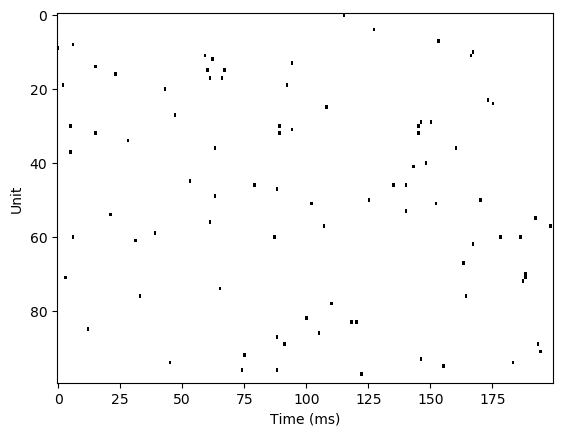

In [6]:
data_id = 1
imshow(hcat([x_data[i][:,data_id] for i in 1:nb_steps]...), cmap=PyPlot.cm.gray_r, aspect="auto")
xlabel("Time (ms)")
ylabel("Unit");

Next, we assign a random label of 0 or 1 to each of our input patterns. Our network's task will be to differentiate these patterns.

In [7]:
y_data = rand(batch_size) .< 0.5;

Note that there is no structure in the data (because it is entirely random). Thus we won't worry about generalization now and only care about our ability to overfit these data with the spiking neural network we are going to build in a jiffy.

In [8]:
device = cpu
#device = gpu #this code does work on a gpu, but it's super slow for unknown reasons

cpu (generic function with 1 method)

### Setup of the spiking network model

Now is the time to implement our LIF neuron model in discrete time.
We will first do this step by step before we wrap all the steps into a function later on.
But first, we fix several model constants such as the membrane and the synaptic time constant. Moreover, we define some essential variables, including our $\alpha$ and $\beta$ as described above (which will take the form of fields in a struct). We do this now because we will use some of these variables to scale our weights to meaningful ranges.

In [9]:
tau_mem = 10f-3
tau_syn = 5f-3;

For each trial, we initialize the synaptic currents and membrane potentials at zero (as the default in the `LIF_layer` constructor)

In [10]:
struct LIF_layer{F,S}
  alpha::F
  beta::F
  state0::S
end

LIF_layer(nb_hidden::Int, batch_size::Int; time_step=1f-3, tau_syn=5f-3, tau_mem=10f-3, init_state=Flux.zeros32) = 
  LIF_layer(exp(-time_step/tau_syn), exp(-time_step/tau_mem), [init_state(nb_hidden, batch_size) for i in 1:2])

@functor LIF_layer

Now we set up our weight matrices, which connect the input and the hidden layer, as well as the matrix connecting the hidden layer with the output layer. Moreover, we initialize these weights randomly from a normal distribution. Note that we scale the variance with the inverse square root of the number of input connections. Moreover, for the sake of simplicity, we ignore Dale's law in this tutorial. Thus weights can be either excitatory or inhibitory. This choice is prevalent in artificial neural networks.

Below, we create a special kind of layer (a linear combination), which we create functions so that we can both initialize it, and call it

In [11]:
struct Linear_layer
  W
end

Linear_layer(in::Integer, out::Integer; σ=1f0) = Linear_layer(σ * randn(Float32, out, in))

# Overload call, so the object can be used as a function
(m::Linear_layer)(x) = m.W * x

@functor Linear_layer

Initialize the layers

In [12]:
beta    = exp(-time_step/tau_mem);
weight_scale = 7f0*(1f0-beta) # this should give us some spikes to begin with

Random.seed!(1)
w1 = Linear_layer(nb_inputs, nb_hidden; σ = Float32(weight_scale/sqrt(nb_inputs)))
w2 = Linear_layer(nb_hidden, nb_outputs; σ = Float32(weight_scale/sqrt(nb_hidden)))

print("init done")

init done

### The spiking nonlinearity (the naive way)

In discrete-time, as explained earlier, we can formulate our spiking nonlinearity as a Heaviside step function. So let's begin with defining a Heaviside function. One way of implementing it is the following:

In [13]:
function spike_fn(x)
    
    S = zero(x)
    S[x .> 0f0] .= 1f0

    return S
    
end

spike_fn (generic function with 1 method)

In [14]:
function d_spike_fn(x)
    
    df = zero(x)
    df[x .== 0f0] .= Inf

    return df
    
end

d_spike_fn (generic function with 1 method)

In Flux, we have to define the gradient of `spike_fn` using the `@adjoint` macro

In [15]:
@adjoint spike_fn(x) = spike_fn(x), c̄ -> (c̄ .* d_spike_fn(x), )

Next, we need to implement a function for the LIF neurons. the `@ignore` macro doesn't include the reset on the backward pass 

In [16]:
function (m::LIF_layer)(h, x)
    
    alpha, beta = m.alpha, m.beta
        
    mem, syn = h[1], h[2]
    
    mthr = mem .- 1f0
    out = spike_fn(mthr)
    
    syn = alpha*syn + x
    mem = (beta*mem + syn) .* @ignore (1f0 .- out)

    return [mem, syn], out
        
end

We make the LIF layer a recurrent one with `Flux.Recur` to make the network 'stateful' so that we don't have to keep track of the network state as it evolves in time. We initialize the LIF layer.

In [17]:
Recur(m::LIF_layer) = Flux.Recur(m, m.state0)

Recur (generic function with 1 method)

We use the `Chain` function to chain together the input layer synapses and the LIF layer.

In [18]:
model_half = Chain(w1, Recur(LIF_layer(nb_hidden, batch_size))) |> device;

In [19]:
x_data = device(x_data);
y_data = device(y_data);
y_data_one_hot = device(onehotbatch(y_data, 0:1));

The, we simulates our neuron models over time and record the membrane potentials and output spikes of all trials and all neurons.

In [20]:
Flux.reset!(model_half)
output = [(model_half(x), model_half[2].state[1]) for x in x_data];

Then, we unpack the outputs, and reorganize them for easilier plotting.

In [21]:
spk_rec = permutedims(Flux.stack([x[1] for x in output], 3), [2,1,3])
mem_rec = permutedims(Flux.stack([x[2] for x in output], 3), [2,1,3]);
mem_rec = cpu(mem_rec)
spk_rec = cpu(spk_rec);

And that's it. The above loop has now simulated our neurons for '''nb_steps''' and stored their membrane traces and output spikes. Let us take a look at those membrane potentials in which we directly "paste" the spikes for visual inspection. We will directly plot multiple trials at once and define a little helper function for this purpose.

In [22]:
function plot_voltage_traces(mem, spk=nothing, dim=(3,5), spike_height=5)
        
    if !isnothing(spk)
        mem[spk .> 0.0] .= spike_height
    end
    
    ax = Array{Any}(undef, prod(dim), 1)
    
    for i in 1:prod(dim)
        
        if i==1
            ax[i] = subplot(dim[1], dim[2], i)
        else
            ax[i] = subplot(dim[1], dim[2], i, sharey=ax[1])
        end
        
        ax[i].plot(mem[i,:,:]')
        ax[i].axis("off")
        
    end
end

plot_voltage_traces (generic function with 4 methods)

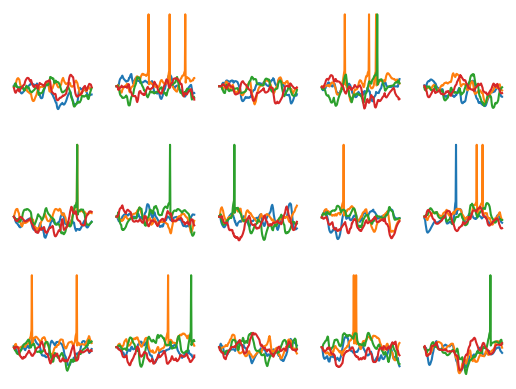

In [23]:
fig=figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

As you can see, our random initialization gives us some sporadic spiking. Thus far, we have only an input layer and a spiking layer, which should become our hidden layer. Next, we will have to add a readout layer to our network.

## Adding a readout layer

To use our network as a classifier, we need to have a readout layer on whose output we can define a cost function. There are several possibilities for doing this. For instance, we could count output layer spikes, or we could directly define an objective function on the membrane potential of the output neurons. Here we will follow the latter approach, but keep in mind that there are many other possibilities of defining an output layer and respective cost functions on them.

In the following, we will build the output layer as a population of leaky integrator neurons. The reason for this choice is that leaky integration is the natural way of how neurons receive the spiking output of their brethren.

We make a function for the leaky integrator layer. We initialize it, make it stateful in the construction.

In [24]:
struct LI_layer{F,S}
  alpha::F
  beta::F
  state0::S
end

LI_layer(nb_outputs::Int, batch_size::Int; time_step=1f-3, tau_syn=5f-3, tau_mem=10f-3, init_state=Flux.zeros32) = 
  LI_layer(exp(-time_step/tau_syn), exp(-time_step/tau_mem), [init_state(nb_outputs, batch_size) for i in 1:2])

function (m::LI_layer)(h, x)
    
    alpha, beta = m.alpha, m.beta
    
    flt, out = h[1], h[2]
    
    flt = alpha*flt + x
    out = beta*out + flt

    return [flt, out], out
        
end

@functor LI_layer

Recur(m::LI_layer) = Flux.Recur(m, m.state0)

Recur (generic function with 2 methods)

Chain it together with the previous layers and the output synapses

In [25]:
model = Chain(model_half, w2, Recur(LI_layer(nb_outputs, batch_size))) |> device;

We can now run this code and plot the output layer "membrane potentials" below. As desired, these potentials do not have spikes riding on them.

We need to reset the state of the stateful layers using `Flux.reset!`

In [26]:
Flux.reset!(model)

Run the model

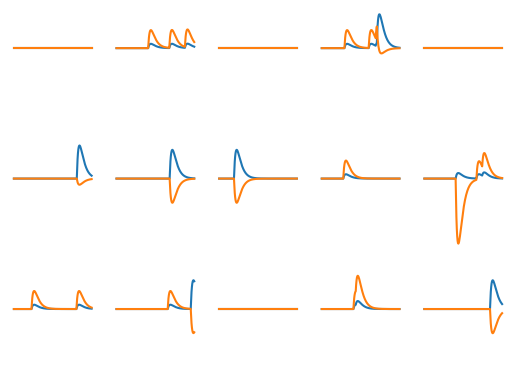

In [27]:
out_rec = permutedims(Flux.stack([model(x) for x in x_data], 3), [2,1,3]);
out_rec = cpu(out_rec);

fig=plt.figure(dpi=100)
plot_voltage_traces(out_rec)

By preventing the output neurons from spiking themselves, we can define a relatively smooth objective on their membrane voltages directly. Specifically, we use the maximum voltage over time of each output unit
$$\hat U^\mathrm{out}_i=\max_t U^\mathrm{out}_i(t)$$
and then use this vector as input for either an argmax to compute the classification accuracy or as we will see below as input for a standard softmax function in conjunction with a negative log-likelihood loss for optimizing the weights in the network. 

Let us first compute the classification accuracy of this random network. We will see that this accuracy is somewhere around 50% as it should be since that corresponds to the chance level of our synthetic task.

In [28]:
function print_classification_accuracy()
    
    """ Dirty little helper function to compute classification accuracy. """
    Flux.reset!(model)
    m = maximum(Flux.stack([model(x) for x in x_data], 3), dims=3) # max over time
        
    am = dropdims(mapslices(argmax, m, dims=1) .- 1f0, dims=1)  # argmax over output units
    acc = mean(y_data .== am) # compare to labels
    @printf "Accuracy %.3f" acc
    
end

print_classification_accuracy (generic function with 1 method)

In [29]:
print_classification_accuracy()

Accuracy 0.496

## Supervised learning

So far, we have built the infrastructure to simulate our spiking neural network, but we have worked with purely random network weights thus far.
The vanilla method to adjust network weights to decrease the specified objective is gradient descent. 
Machine learning libraries like Tensorflow, PyTorch, and Flux.jl make implementing gradient descent a breeze.
We first perform gradient descent on the correct gradient and use this as a motivation for introducing surrogate gradients.
Here we go.

### Supervised learning with the true gradient

Reinitalize the weights

In [30]:
Random.seed!(1)
w1 = Linear_layer(nb_inputs, nb_hidden; σ = Float32(weight_scale/sqrt(nb_inputs)))
w2 = Linear_layer(nb_hidden, nb_outputs; σ = Float32(weight_scale/sqrt(nb_hidden)))

Linear_layer(Float32[0.0560241 0.043700736 0.28973216 -0.009669799; -0.6549718 0.18173656 -0.24359122 0.28016877])

Initialize the model

In [31]:
model_half = Chain(w1, Recur(LIF_layer(nb_hidden, batch_size))) |> device
model = Chain(model_half, w2, Recur(LI_layer(nb_outputs, batch_size))) |> device;

Use the `ADAM` optimizer

In [32]:
opt = ADAM(2e-3, (0.9, 0.999));

Specify the parameters to be optimized

In [33]:
parameters = params(model);

Define the loss function 

In [34]:
function loss(x, y) 
    
    Flux.reset!(model)
    m = maximum(Flux.stack([model(x) for x in x_data], 3), dims=3) # max over time;
    logitcrossentropy(m, y)
    
end

loss (generic function with 1 method)

In [35]:
loss(x_data, y_data_one_hot)

0.72729594f0

This is how to compute the gradients of the loss in Flux.jl

In [36]:
grads = gradient(() -> loss(x_data, y_data_one_hot), parameters)

Grads(...)

In [37]:
# The optimization loop
loss_hist = Array{Float32}(undef, 1000)

for e in 1:length(loss_hist)
    
    #get the loss function
    loss_val, back = Zygote.pullback(() -> loss(x_data, y_data_one_hot), parameters)
    
    #get the gradient
    gs = back(one(loss_val))

    # Update the parameters based on the chosen
    # optimiser (opt)
    Flux.Optimise.update!(opt, parameters, gs)
    
    loss_hist[e] = loss_val
    mod(e, Int(0.05 * length(loss_hist)))  == 0 ? println("train_loss = $loss_val") : nothing
    
end
    
loss_hist_true_grad = loss_hist; # store for later use

train_loss = 0.7037446
train_loss = 0.6919211
train_loss = 0.6846036
train_loss = 0.6818635
train_loss = 0.6805839
train_loss = 0.68030155
train_loss = 0.68010294
train_loss = 0.67998075
train_loss = 0.6799173
train_loss = 0.67989737
train_loss = 0.6798925
train_loss = 0.6798885
train_loss = 0.67988735
train_loss = 0.67988497
train_loss = 0.67988163
train_loss = 0.6798786
train_loss = 0.67987853
train_loss = 0.6798768
train_loss = 0.6798789
train_loss = 0.6798741


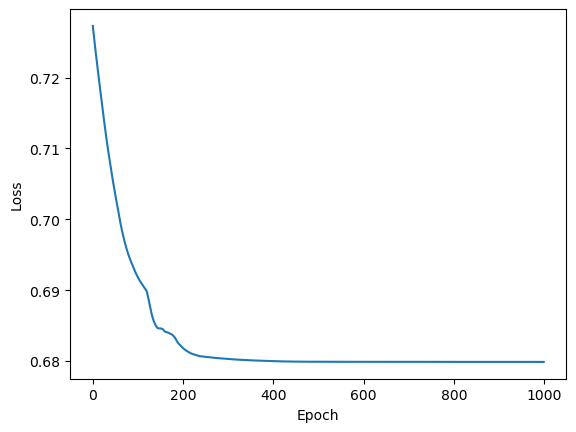

In [38]:
plot(loss_hist);
xlabel("Epoch")
ylabel("Loss");

In [39]:
print_classification_accuracy()

Accuracy 0.543

We appreciate that loss decreases over iterations and converges towards a steady state. The classification accuracy, however, does not seem to improve dramatically throughout the optimization. What a shame! 

The underlying reason is that the nonlinearity of the hidden units have zero derivatives everywhere except at threshold crossings, where they become infinite. In practice that means that weight updates in the hidden layer vanish and the weights remain unmodified. By plotting the hidden layer activations and comparing them with what we have plotted before, we will see that these activations have not changed at all. Thus no learning happens in the hidden layer. The reason why the loss decreased initially during optimization is that the output layer weights could still change and allow for some improvement (even if it was very little).

To improve performance, we need to get the hidden layer units to take part in learning. To achieve this, we will introduce a surrogate gradient in the next section.

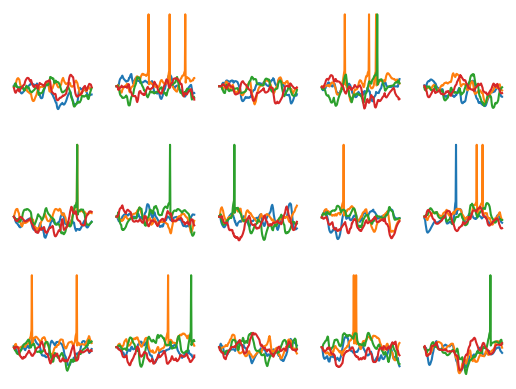

In [40]:
Flux.reset!(model)
output = [(model_half(x), model_half[2].state[1]) for x in x_data];

spk_rec = permutedims(Flux.stack([x[1] for x in output], 3), [2,1,3])
mem_rec = permutedims(Flux.stack([x[2] for x in output], 3), [2,1,3]);
mem_rec = cpu(mem_rec)
spk_rec = cpu(spk_rec);

fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

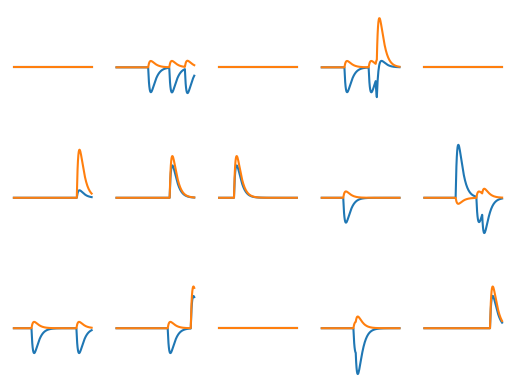

In [41]:
Flux.reset!(model)
output = permutedims(Flux.stack([model(x) for x in x_data], 3), [2,1,3]);
output = cpu(output);

fig=plt.figure(dpi=100)
plot_voltage_traces(output)

### Supervised learning with surrogate gradients

In the last section, we saw that the hidden layer units did not participate.
The underlying reason is that the partial derivative of the step function we used has a vanishing derivative everywhere (except at zero where it becomes infinite).

Most conventional neural networks avoid this problem by choosing a nonlinearity with non-zero partial derivative. For instance, sigmoidal or tanh units were standard during the beginnings of neural networks research. Today, ReLUs are more common. Importantly, all these activation functions have substantial non-zero support, which allows gradients to flow (to a greater or lesser extent).

What do we if we want to stick to our binary nonlinearity? There have been several approaches to tackle this problem. Here we use one such strategy which has been applied successfully to spiking neural networks: We use a surrogate gradient approach.

The idea behind a surrogate gradient is dead simple. Instead of changing the nonlinearity itself, we only change the gradient. Thus we use a different "surrogate" gradient to optimize parameters that would otherwise have a vanishing gradient.

<img src="figures/surrgrad/surrgrad.png" width="450">
Specifically, we use the partial derivative of a function which to some extent approximates the stepfunction $\Theta(x)$.
In what follows, chiefly, we will use (up to rescaling) the partial derivative of a fast sigmoid function $\sigma(x)$. 
While $\Theta$ is invariant to multiplicative rescaling, $\sigma$ isn't. Thus we have to introduce a scale parameter.

We now write over our initial `spike_fn` with a new gradient

In [42]:
function spike_fn(x; g=100)
    
    S = zero(x)
    S[x .> 0f0] .= 1f0

    return S
    
end

spike_fn (generic function with 1 method)

In [43]:
dfastsig(x,g) =  (1 ./ (g * abs.(x) .+ 1.0).^2)
@adjoint spike_fn(x;g=100) = spike_fn(x;g=g), c̄ -> (c̄ .* dfastsig(x,g), )

Reinitalize the weights

In [44]:
Random.seed!(1)
w1 = Linear_layer(nb_inputs, nb_hidden; σ = Float32(weight_scale/sqrt(nb_inputs)))
w2 = Linear_layer(nb_hidden, nb_outputs; σ = Float32(weight_scale/sqrt(nb_hidden)))
print("init done")

init done

Re-initialize the model

In [45]:
model_half = Chain(w1, Recur(LIF_layer(nb_hidden, batch_size))) |> device
model = Chain(model_half, w2, Recur(LI_layer(nb_outputs, batch_size))) |> device;
parameters = Flux.params(model);

Now re-train using the surrograte gradient

In [46]:
# The optimization loop
loss_hist = Array{Float32}(undef, 1000)

for e in 1:length(loss_hist)
        
    #get the loss function
    loss_val, back = Zygote.pullback(() -> loss(x_data, y_data_one_hot), parameters)
    
    #get the gradient
    gs = back(one(loss_val))

    # Update the parameters based on the chosen
    # optimiser (opt)
    Flux.Optimise.update!(opt, parameters, gs)
    
    loss_hist[e] = loss_val
    mod(e, Int(0.05 * length(loss_hist)))  == 0 ? println("train_loss = $loss_val") : nothing      
    
end

train_loss = 0.56276613
train_loss = 0.43655032
train_loss = 0.33274558
train_loss = 0.2486441
train_loss = 0.19299005
train_loss = 0.14603862
train_loss = 0.13279799
train_loss = 0.10811307
train_loss = 0.10064715
train_loss = 0.09961612
train_loss = 0.088768415
train_loss = 0.08485116
train_loss = 0.090083346
train_loss = 0.07427188
train_loss = 0.06909807
train_loss = 0.067838214
train_loss = 0.06235959
train_loss = 0.06561432
train_loss = 0.067252025
train_loss = 0.05957974


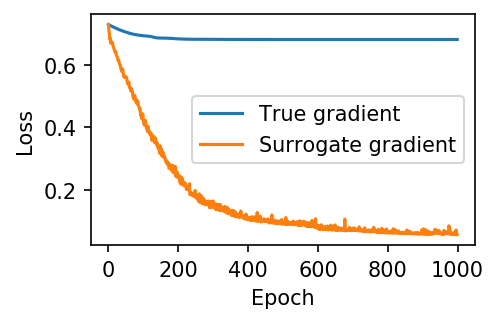

In [47]:
figure(figsize=(3.3,2),dpi=150)
plot(loss_hist_true_grad, label="True gradient")
plot(loss_hist, label="Surrogate gradient")
xlabel("Epoch")
ylabel("Loss")
legend();

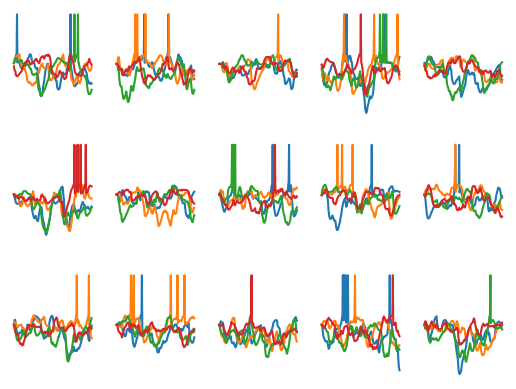

In [48]:
Flux.reset!(model)
output = [(model_half(x), model_half[2].state[1]) for x in x_data]
spk_rec = permutedims(Flux.stack([x[1] for x in output], 3), [2,1,3])
mem_rec = permutedims(Flux.stack([x[2] for x in output], 3), [2,1,3]);
mem_rec = cpu(mem_rec)
spk_rec = cpu(spk_rec);

fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

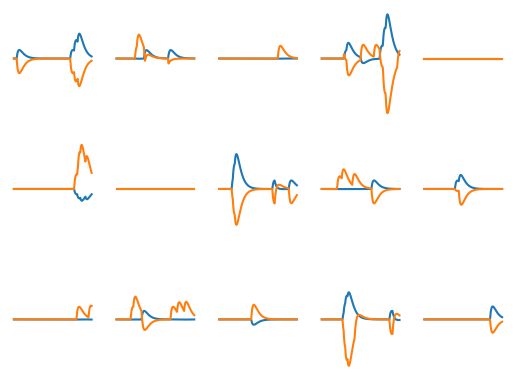

In [49]:
Flux.reset!(model)
output = permutedims(Flux.stack([model(x) for x in x_data], 3), [2,1,3]);
output = cpu(output);

fig=plt.figure(dpi=100)
plot_voltage_traces(output)

In [50]:
print_classification_accuracy()

Accuracy 0.969